# Pre-processing

Our goal in this project is to predict the customer lifetime value (LTV). Since we don't have customer information in our Amazon sales data, we'll use the International sales data.

In [31]:
#import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
int_df=pd.read_csv('international_sales_2.csv')
int_df.head()

,Order_ID,Date,Month,Customer_name,Style,SKU,Size,Quantity,Price,Total,Stock,Shipping(per order)
0,-6056861894448732620,2021-06-05,Jun-21,Revathy Loganathan,MEN5004,MEN5004-KR-L,L,1,616.56,617.0,8.0,2250.0
1,-6056861894448732620,2021-06-05,Jun-21,Revathy Loganathan,MEN5004,MEN5004-KR-XL,XL,1,616.56,617.0,4.0,2250.0
2,-6056861894448732620,2021-06-05,Jun-21,Revathy Loganathan,MEN5004,MEN5004-KR-XXL,XXL,1,616.56,617.0,6.0,2250.0
3,-6056861894448732620,2021-06-05,Jun-21,Revathy Loganathan,MEN5009,MEN5009-KR-L,L,1,616.56,617.0,6.0,2250.0
4,-6056861894448732620,2021-06-05,Jun-21,Revathy Loganathan,MEN5011,MEN5011-KR-L,L,1,616.56,617.0,11.0,2250.0


But before predicting the LTW we need to segment our customers to adopt our actions depending on their different needs and behavior. In order to do that we'll use the RFM method which stands for Recency - Frequency - Monetary Value. </br>
The first step would be to to calculate the metrics mentioned above for each customer. We'll start with recency.

### Recency

In [3]:
int_df['Date']=pd.to_datetime(int_df['Date'])

purchase_df=int_df.groupby('Customer_name')['Date'].max().reset_index()
purchase_df.columns=['Customer_name', 'MaxPurchaseDate']
max_date=purchase_df['MaxPurchaseDate'].max()
purchase_df['Recency']=(max_date - purchase_df['MaxPurchaseDate']).dt.days
purchase_df['Recency'].describe()

count    153.000000
mean     130.346405
std      103.101976
min        0.000000
25%       43.000000
50%       95.000000
75%      218.000000
max      337.000000
Name: Recency, dtype: float64

So the average recency period is 130 days but the median value is 95.Let's plot the values to have a better look at the recency distribution.

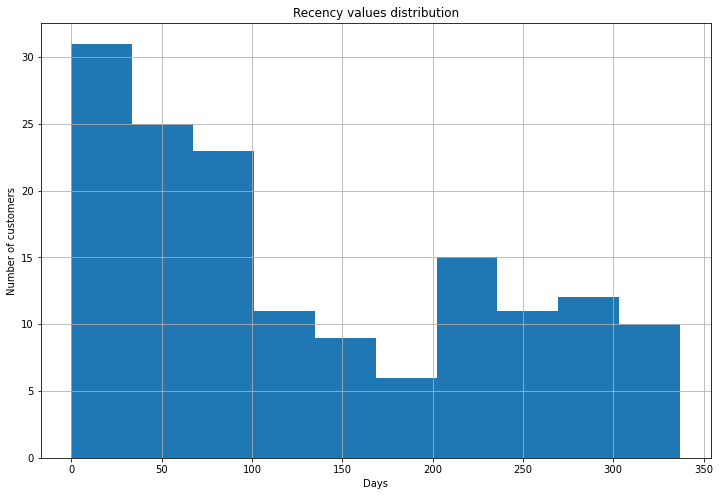

In [4]:
purchase_df['Recency'].hist(figsize=(12, 8))
plt.title('Recency values distribution')
plt.xlabel('Days')
plt.ylabel('Number of customers')
plt.show()

Now we need to assign a recency score to our values. In order to do it we'll use KMeans clustering. But first we need to choose the number of clusters we need. To find it out, we'll use the elbow method.

C:\Users\sirak\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


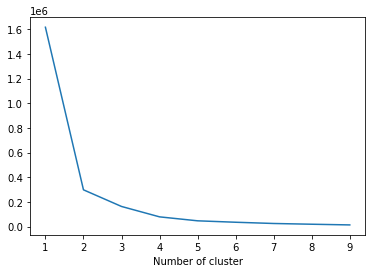

In [5]:
sse={}
Recency = purchase_df[['Recency']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(Recency)
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

It looks like 3 is the optimal one.Now let's build our clusters.

In [6]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(purchase_df[['Recency']])
purchase_df['RecencyCluster']=kmeans.predict(purchase_df[['Recency']])

#We'll also add a function for ordering the clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

purchase_df=order_cluster('RecencyCluster', 'Recency', purchase_df, False)

In [7]:
purchase_df.groupby('RecencyCluster').describe()

Recency                                                     \
                 count        mean        std    min    25%    50%    75%   
RecencyCluster                                                              
0                 33.0  285.636364  31.907893  237.0  259.0  284.0  316.0   
1                 35.0  181.800000  36.330833  118.0  148.0  194.0  210.5   
2                 85.0   48.870588  31.921327    0.0   20.0   44.0   75.0   

                       
                  max  
RecencyCluster         
0               337.0  
1               232.0  
2               114.0

So we can clearly see the difference between the 3 clusters. The cluster 2 has the customers with the most recent purchase dates and it is the biggest cluster. The cluster 0 and 1 have customers with bigger recency values and have almost the same number of customers.

## Frequency

To create frequency clusters, we need to find total number of orders for each customer.

In [8]:
frequency_df=int_df.groupby('Customer_name')['Order_ID'].count().reset_index()
frequency_df.columns = ['Customer_name','Frequency']

purchase_df=pd.merge(purchase_df, frequency_df, on='Customer_name')
purchase_df.head()

,Customer_name,MaxPurchaseDate,Recency,RecencyCluster,Frequency
0,Aanchol,2021-07-16,299,0,4
1,Akash Kaushal,2021-09-07,246,0,10
2,Arkh Fashion,2021-08-16,268,0,32
3,Aruna Devi,2021-07-24,291,0,42
4,Bincy Skaria,2021-08-25,259,0,148


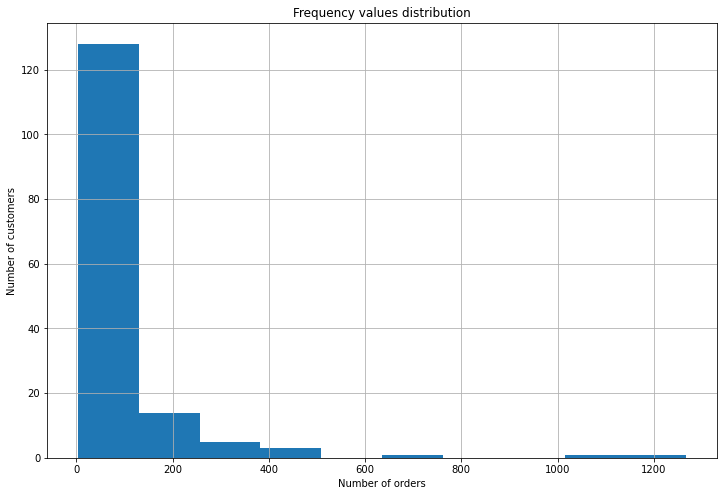

In [9]:
purchase_df['Frequency'].hist(figsize=(12, 8))
plt.title('Frequency values distribution')
plt.xlabel('Number of orders')
plt.ylabel('Number of customers')
plt.show()

In [10]:
purchase_df['Frequency'].describe()

count     153.000000
mean       83.496732
std       156.631445
min         3.000000
25%        17.000000
50%        32.000000
75%        74.000000
max      1268.000000
Name: Frequency, dtype: float64

As we can see we have some outliers in our frequency values. The mean value is 83 orders whereas the median is 32 and the max value is 1268. We'll try to plot the results without the outliers.

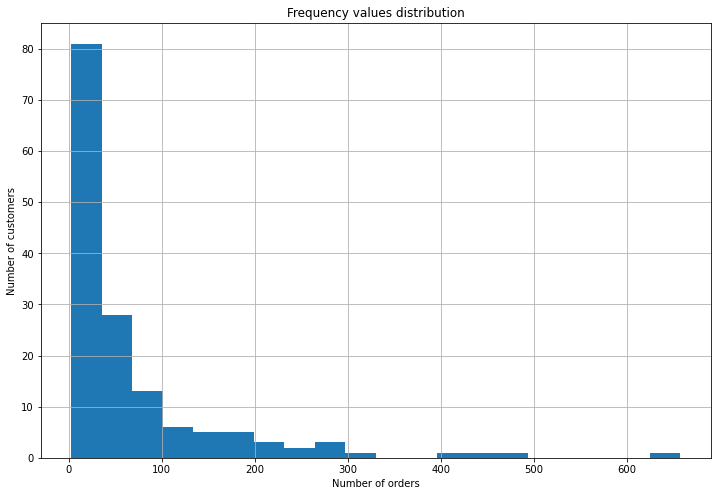

In [11]:
purchase_df.query('Frequency < 1000')['Frequency'].hist(figsize=(12, 8), bins=20)
plt.title('Frequency values distribution')
plt.xlabel('Number of orders')
plt.ylabel('Number of customers')
plt.show()

Now we'll try to find the frequency clusters applying the same logic.

In [12]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(purchase_df[['Frequency']])
purchase_df['FrequencyCluster']=kmeans.predict(purchase_df[['Frequency']])

purchase_df=order_cluster('FrequencyCluster', 'Frequency', purchase_df, True)

In [13]:
purchase_df.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,129.0,36.248062,29.638718,3.0,14.0,27.0,48.0,135.0
1,21.0,245.619048,93.589249,148.0,179.0,224.0,275.0,463.0
2,3.0,980.333333,307.057541,657.0,836.5,1016.0,1142.0,1268.0


The frequency cluster sizes are more unbalanced compared to recency clusters. The 0 cluster has the most of the customers with the mean value of 27 orders. The cluster 1 has 21 customers with the mean value of 245 orders. And the cluster 2 has all the outliers: these are the best 3 customers in terms of Frequency. They've made 657 to 1268 purchases in one year.

## Revenue

For the Monetary value we'll calculate the Revenue because we don't have the cost information for every customer. We'll take the 'Total' column from the original dataset which represents the total amount of money spent on every item purchase. Since we need the revenue for every customer, we'll group the data by the 'Customer_name' column.

In [14]:
revenue_df = int_df.groupby('Customer_name')['Total'].sum().reset_index()
revenue_df.columns = ['Customer_name','Revenue']

purchase_df=pd.merge(purchase_df, revenue_df, on='Customer_name')
purchase_df.head()

,Customer_name,MaxPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,Aanchol,2021-07-16,299,0,4,0,11452.0
1,Akash Kaushal,2021-09-07,246,0,10,0,5580.0
2,Arkh Fashion,2021-08-16,268,0,32,0,32690.0
3,Aruna Devi,2021-07-24,291,0,42,0,26952.0
4,Faria Essopp,2021-06-08,337,0,54,0,27989.0


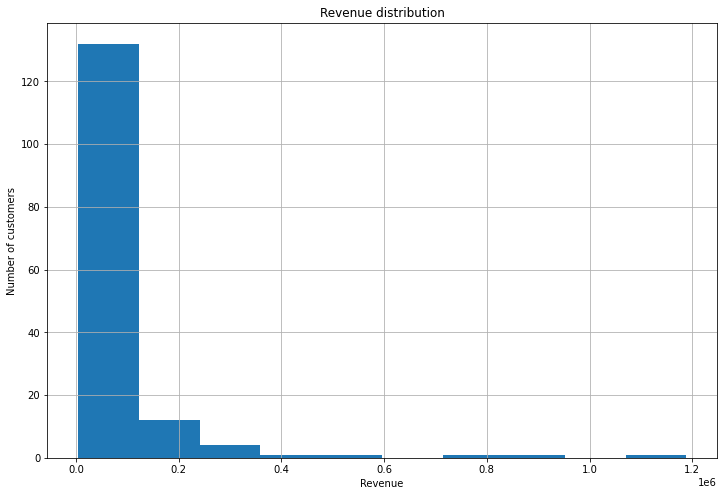

In [15]:
purchase_df['Revenue'].hist(figsize=(12, 8))
plt.title('Revenue distribution')
plt.xlabel('Revenue')
plt.ylabel('Number of customers')
plt.show()

In [16]:
round(purchase_df['Revenue'].describe(), 2)

count        153.00
mean       72965.59
std       149641.75
min         3380.00
25%        13041.00
50%        26950.00
75%        62684.00
max      1188815.50
Name: Revenue, dtype: float64

Revenue has a similar to Frequency distribution of values: there are some outliers and the median value is few times smaller than the mean. Now let's find the clusters for the Revenue.

In [17]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(purchase_df[['Revenue']])
purchase_df['RevenueCluster']=kmeans.predict(purchase_df[['Revenue']])

purchase_df=order_cluster('RevenueCluster', 'Revenue', purchase_df, True)

In [18]:
purchase_df.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,132.0,30783.626439,26162.146541,3380.0,12112.00,21411.0,40275.50,119863.0
1,18.0,235858.000000,107217.359285,136428.0,155702.25,208325.0,265638.25,544586.0
2,3.0,951617.500000,212162.946089,779953.0,833018.50,886084.0,1037449.75,1188815.5


The sizes of the clusters and the difference between mean and median values are similar to the ones for frequency clusters. </br>
Now that we have all the metrics and the clusters for them let's create a new column "Overall_Score" which will summarize all the cluster values and divide the customers into 3 different groups based on overall score.

In [19]:
purchase_df['OverallScore'] = purchase_df['RecencyCluster'] + purchase_df['FrequencyCluster'] + purchase_df['RevenueCluster']
round(purchase_df.groupby('OverallScore')[['Recency','Frequency','Revenue']].describe(), 2)

Recency                                                      \
               count    mean    std    min     25%    50%     75%    max   
OverallScore                                                               
0               28.0  286.46  32.19  237.0  263.50  285.5  316.25  337.0   
1               28.0  186.96  46.53  118.0  148.50  198.0  212.00  321.0   
2               76.0   56.16  50.93    0.0   19.50   44.0   76.50  280.0   
3               10.0  139.50  96.51   11.0   55.25  134.0  215.75  306.0   
4               10.0   98.80  67.32   27.0   64.50   79.5   93.25  239.0   
6                1.0   36.00    NaN   36.0   36.00   36.0   36.00   36.0   

             Frequency           ...                  Revenue              \
                 count     mean  ...      75%     max   count        mean   
OverallScore                     ...                                        
0                 28.0    30.43  ...    42.25    98.0    28.0    24277.57   
1                 28.0    43.57  ...    52.50   148.0    28.0    36218.64   
2                 76.0    41.74  ...    54.00   191.0    76.0    37047.61   
3                 10.0   235.90  ...   225.50   657.0    10.0   170919.30   
4                 10.0   390.40  ...   431.00  1016.0    10.0   375621.40   
6                  1.0  1268.00  ...  1268.00  1268.0     1.0  1188815.50   

                                                                       \
                    std        min         25%        50%         75%   
OverallScore                                                            
0              18804.24     5058.0     9598.50    18115.5    34090.25   
1              33803.54     8430.0    13622.00    25164.5    41669.75   
2              52348.37     3380.0    12592.75    18763.5    41224.50   
3              78728.11    75422.0   121916.25   151782.0   207867.50   
4             267221.65   139172.0   213079.00   261589.5   483781.25   
6                   NaN  1188815.5  1188815.50  1188815.5  1188815.50   

                         
                    max  
OverallScore             
0               65504.0  
1              154858.0  
2              403253.0  
3              345265.0  
4              886084.0  
6             1188815.5  

[6 rows x 24 columns]

So we have 6 clusters of customers. We can clearly see the difference between all the columns except the column 2, which has large range of values for all metrics because of its size (almost half of the values are in this cluster). Now we'll divide the customers into 3 groups based on the overall score.

In [20]:
purchase_df['Segment'] = 'Low value'
purchase_df.loc[purchase_df['OverallScore']>1,'Segment'] = 'Mid value' 
purchase_df.loc[purchase_df['OverallScore']>2,'Segment'] = 'High value' 

Let's plot 3 histograms showing the relationships between our metrics for every segment. 

In [21]:
purchase_df.head()

,Customer_name,MaxPurchaseDate,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,Aanchol,2021-07-16,299,0,4,0,11452.0,0,0,Low value
1,Akash Kaushal,2021-09-07,246,0,10,0,5580.0,0,0,Low value
2,Arkh Fashion,2021-08-16,268,0,32,0,32690.0,0,0,Low value
3,Aruna Devi,2021-07-24,291,0,42,0,26952.0,0,0,Low value
4,Faria Essopp,2021-06-08,337,0,54,0,27989.0,0,0,Low value


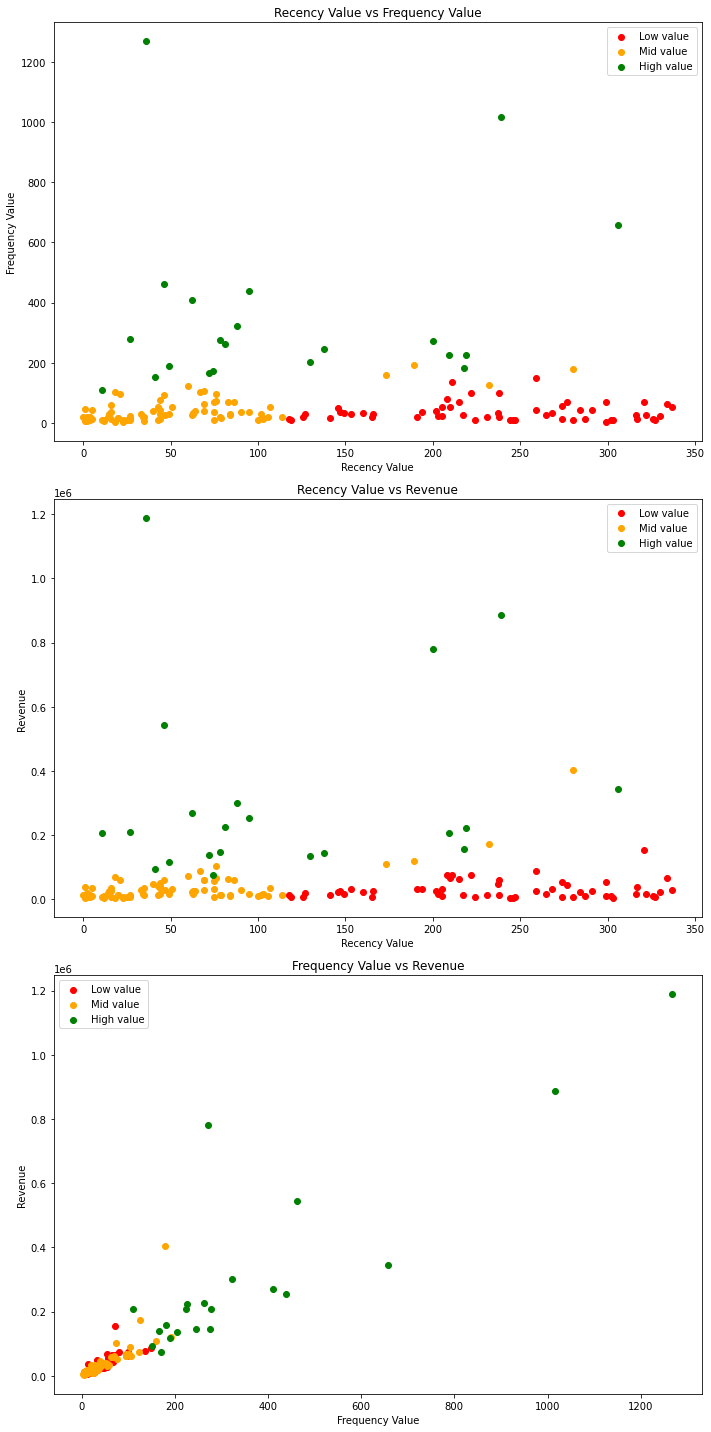

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))
colors = {'Low value': 'red', 'Mid value': 'orange', 'High value': 'green'}

# Recency vs Frequency
for segment, color in colors.items():
    subset = purchase_df[purchase_df['Segment'] == segment]
    ax[0].scatter(subset['Recency'], subset['Frequency'], c=color, label=str(segment))
ax[0].set_xlabel('Recency Value')
ax[0].set_ylabel('Frequency Value')
ax[0].legend()
ax[0].set_title('Recency Value vs Frequency Value')

# Recency vs Revenue
for segment, color in colors.items():
    subset = purchase_df[purchase_df['Segment'] == segment]
    ax[1].scatter(subset['Recency'], subset['Revenue'], c=color, label=str(segment))
ax[1].set_xlabel('Recency Value')
ax[1].set_ylabel('Revenue')
ax[1].legend()
ax[1].set_title('Recency Value vs Revenue')

# Frequency vs Revenue
for segment, color in colors.items():
    subset = purchase_df[purchase_df['Segment'] == segment]
    ax[2].scatter(subset['Frequency'], subset['Revenue'], c=color, label=str(segment))
ax[2].set_xlabel('Frequency Value')
ax[2].set_ylabel('Revenue')
ax[2].legend()
ax[2].set_title('Frequency Value vs Revenue')

plt.tight_layout()
plt.show()

We can see how the segments are clearly differentiated from each other in terms of RFM. </br>
- For the low value and mid value segments the revenue and frequency levels are quite similar to each other and need to be improved. The biggest difference between these segments is in recency: mid value customers have much lower recency rates.
- Some of the high value customers have high recency value which should be improved. In terms of frequency and revenue the high value segment has clearly better results and it still can be improved.</br>

### So, here are the main strategies for different segments:

#### - High Value: Improve Retention 
#### - Mid Value: Increase Frequency 
#### - Low Value: Improve Retention + Increase Frequency

In [23]:
purchase_df.to_csv('Purchase_df.csv', index=False)

## Customer lifetime value (LTV) prediction

In order to calculate the LTV first we need to select a time window. Considering the fact that we have data for 11 months we can predict the LTV for the last 5 months using the first 6 months of data. We can use RFM scores as features for our model. Let's start by spliting the data and calculating the RFM metrics for the first 6 months.

In [24]:
print(int_df['Date'].max().date())
print(int_df['Date'].min().date())

2022-05-11
2021-06-05


In [25]:
first6m_df=int_df[(int_df['Date'].dt.date<dt.date(2021, 11, 30))].reset_index(drop=True)
last5m_df=int_df[(int_df['Date'].dt.date>=dt.date(2021, 11, 30))].reset_index(drop=True)

In [26]:
#Recency
first6m_purchase_df=first6m_df.groupby('Customer_name')['Date'].max().reset_index()
first6m_purchase_df.columns=['Customer_name', 'MaxPurchaseDate']
max_date=first6m_purchase_df['MaxPurchaseDate'].max()
first6m_purchase_df['Recency']=(max_date - first6m_purchase_df['MaxPurchaseDate']).dt.days

kmeans=KMeans(n_clusters=3)
kmeans.fit(first6m_purchase_df[['Recency']])
first6m_purchase_df['RecencyCluster']=kmeans.predict(first6m_purchase_df[['Recency']])
first6m_purchase_df=order_cluster('RecencyCluster', 'Recency', first6m_purchase_df, False)

#Frequency
frequency_df=first6m_df.groupby('Customer_name')['Order_ID'].count().reset_index()
frequency_df.columns = ['Customer_name','Frequency']
first6m_purchase_df=pd.merge(first6m_purchase_df, frequency_df, on='Customer_name')

kmeans=KMeans(n_clusters=3)
kmeans.fit(first6m_purchase_df[['Frequency']])
first6m_purchase_df['FrequencyCluster']=kmeans.predict(first6m_purchase_df[['Frequency']])
first6m_purchase_df=order_cluster('FrequencyCluster', 'Frequency', first6m_purchase_df, True)

#Revenue
revenue_df = first6m_df.groupby('Customer_name')['Total'].sum().reset_index()
revenue_df.columns = ['Customer_name','Revenue']
first6m_purchase_df=pd.merge(first6m_purchase_df, revenue_df, on='Customer_name')

kmeans=KMeans(n_clusters=3)
kmeans.fit(first6m_purchase_df[['Revenue']])
first6m_purchase_df['RevenueCluster']=kmeans.predict(first6m_purchase_df[['Revenue']])
first6m_purchase_df=order_cluster('RevenueCluster', 'Revenue', first6m_purchase_df, True)

#Overall score and segments
first6m_purchase_df['OverallScore'] = first6m_purchase_df['RecencyCluster'] + first6m_purchase_df['FrequencyCluster'] + first6m_purchase_df['RevenueCluster']
first6m_purchase_df['Segment'] = 'Low value'
first6m_purchase_df.loc[first6m_purchase_df['OverallScore']>1,'Segment'] = 'Mid value' 
first6m_purchase_df.loc[first6m_purchase_df['OverallScore']>3,'Segment'] = 'High value' 

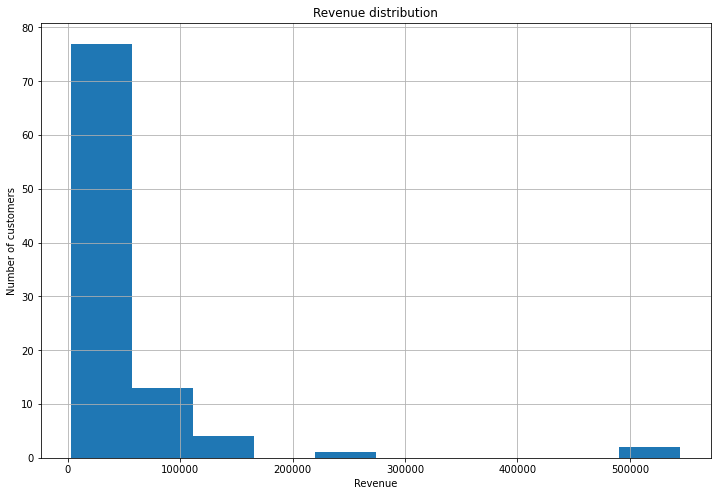

In [27]:
#Calculating the LTV for the last 5 months
last5m_purchase_df = last5m_df.groupby('Customer_name')['Total'].sum().reset_index()
last5m_purchase_df.columns = ['Customer_name','l5_Revenue']

last5m_purchase_df['l5_Revenue'].hist(figsize=(12, 8))
plt.title('Revenue distribution')
plt.xlabel('Revenue')
plt.ylabel('Number of customers')
plt.show()

We can notice the outliers in our model which should be filtered out to have a proper machine learning model. Now let's merge our datasets and build our first model.

# Modeling

In [28]:
#merging the datasets
merged_df = pd.merge(first6m_purchase_df, last5m_purchase_df, on='Customer_name', how='left')
merged_df = merged_df.fillna(0)

#filtering out the outliers
merged_df = merged_df[merged_df['l5_Revenue']<merged_df['l5_Revenue'].quantile(0.9)]

X = merged_df[['Recency', 'Frequency', 'Revenue']]
y = merged_df['l5_Revenue']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

rmse_train, rmse_test

(0.003164014420963531, 11756.955061174276)

The root mean squared error (RMSE) on the training set is approximately 0.003, and on the test set, it's approximately 11771.1.

The large difference in the RMSE for the training set and the test set suggests that the model might be overfitting to the training data. In order to deal with this we'll try to tune our hyperparameters. We'll use RandomizedSearchCV.

In [33]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'reg_lambda': [1, 1.5, 2], 
    'reg_alpha': [0, 0.5, 1],
}
xgb = XGBRegressor()
grid_cv = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_cv.fit(X_train, y_train)
best_params = grid_cv.best_params_

xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train, y_train)

y_train_pred_best = xgb_best.predict(X_train)
y_test_pred_best = xgb_best.predict(X_test)

rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))

best_params, rmse_train_best, rmse_test_best

({'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 100,
  'reg_alpha': 1,
  'reg_lambda': 2},
 5842.419316484407,
 8806.604902482515)

This is an improvement over our previous model, but the results are not practical considering the fact that rmse on test set is close to the mean value of our target column. This could be due to several reasons:

- Limited Data: With more data, the model might be able to generalize better.
- Outliers: If there are outliers in the target variable (i.e., some customers have extremely high future monetary values), this could be influencing the model's performance.

Overall, while the model's performance is not perfect, it could still provide valuable insights for making business decisions. For example, it could help to identify customers who are predicted to have high future monetary values, so that marketing efforts can be focused on retaining these customers.